In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso
from sklearn.metrics import roc_auc_score, auc, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report
from test_function import *
import random
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from test_function import *
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
f = open("/storage/home/jkl5991/group/dbnsfp/tabix_try/tabixindex.txt") #load index name
header = f.readline().strip().split('\t')
f.close()

omit_model = pd.read_csv("/storage/home/jkl5991/group/dbnsfp/tabix_try/tabix_omit.tsv", sep = '\t', names = header)
balanced_model = pd.read_csv("/storage/home/jkl5991/group/dbnsfp/tabix_try/tabix_balanced.tsv", sep = '\t', names = header)

f = open("/storage/home/jkl5991/group/dbnsfp/tabix_try/backup_noMPC_primateAI/tabixindex.txt")
header2 = f.readline().strip().split('\t')
omit_model_original = pd.read_csv("/storage/home/jkl5991/group/dbnsfp/tabix_try/backup_noMPC_primateAI/tabix_omit.tsv", sep = '\t', names = header2)

/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
omit = pd.read_csv('unannotated_omit_std.tsv', sep = '\t')
dominant = pd.read_csv('dominant_std.tsv', sep = '\t')
recessive = pd.read_csv("recessive_std.tsv",sep = '\t')

omit_with_criteria = pd.read_csv('omit_with_criteria.tsv', sep = '\t')

In [4]:
def merge_with_original_df(originaldf, newdf):
    newdf['location'] = newdf['chr'] + '-' + newdf['pos-1'].map(str)+ '-' + newdf['pos'].map(str)+ '-' + newdf['ref'].map(str)+ '-' + newdf['alt'].map(str)
    result = pd.merge(originaldf, newdf, on=['location'])
    result = result.drop(columns = ['chr', 'pos-1', 'pos', 'ref', 'alt'])
    return(result)

def fitting_gb(Xtrain, ytrain, Xtest, ytest, learning, depth, estimator, randomseed =42):
    #np.random.seed(randomseed)
    model = GradientBoostingClassifier(learning_rate = learning, max_depth = depth, n_estimators = estimator, subsample = 1)
    
    model.fit(Xtrain, ytrain)
    
    model_pred = model.decision_function(Xtest)
    
    return(ytest, model_pred, model)


def drawROC(ytest, ytest_hat, lw=2, linestyle = '--', label = '', lastone = False, MoreThanOnelocation = 'lower right', fontsize = 12, title = '', legendloc = ''):
    fpr, tpr, thresholds = roc_curve(ytest, ytest_hat)
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr, tpr, lw = lw, linestyle = linestyle, label = label + ', (AUC = %0.3f)'%roc_auc)
    if (lastone == True):
        plt.legend(bbox_to_anchor= (1.1, 1.0))
   
        plt.title(title)
        plt.show()
        
        
def tun_gb(Xtrain, ytrain, tuned_parameters):
    np.random.seed(42)
    clf = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, scoring='%s_macro' % 'recall')
    clf.fit(Xtrain, ytrain)

    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print("With score : %0.3f\n"%clf.best_score_)
    print("Grid scores on development set:\n")
    return(clf.best_params_)

In [5]:
## input: X and Y, 
## output: X,y training/testing/validation data

def savesemicol(df, col):
    col_max = []
    for i in df[col].str.split(';') :
        col_max.append(max(i))
        
    df[col] = np.array(col_max)
    return(df)

def save_allsemicol(df, columnname):
    for n in columnname:
        df = savesemicol(df, n)
        
    return(df)

    
def split(df, Xname, Yname, testsize = 0.1):
    for i in Xname:
        df.drop(df.loc[df[i] == '.'].index, inplace= True)
        
    #df = df.dropna()
    X = df.loc[:,Xname]           
    
    y = df.loc[:,[Yname]].values.flatten()
    
    
    Xtrain, Xtest, ytrain, ytest = train_test_split(X,y, test_size = testsize, random_state = 42)    
    Xtrain, Xvalid, ytrain, yvalid =  train_test_split(Xtrain,ytrain, test_size = 0.11, random_state = 42)
    
    return(Xtrain, Xvalid, Xtest, ytrain, yvalid, ytest, df)


In [6]:
## FATHMM special case

FATHMM_score =[]
for i in omit_model['FATHMM_score'].str.split(';')[:]:
    i = list(filter(lambda a: a != '.', i))
    ## to prevent there are NAs in the data
    if len(i) == 0:
        FATHMM_score.append('.')
        
    ## reversing thier sign
    else:
        FATHMM_score.append(float(min(i))*(-1))
omit_model['FATHMM_score'] = np.array(FATHMM_score)

## balanced model
FATHMM_score =[]
for i in balanced_model['FATHMM_score'].str.split(';')[:]:
    i = list(filter(lambda a: a != '.', i))
    if len(i) == 0:
        FATHMM_score.append('.')
    else:
        FATHMM_score.append(float(min(i))*(-1))
balanced_model['FATHMM_score'] = np.array(FATHMM_score)

In [7]:
omit_model_all = save_allsemicol(omit_model,['VEST4_score','MPC', 'LIST-S2_score'])
balanced_model_all = save_allsemicol(balanced_model,['VEST4_score','MPC', 'LIST-S2_score'])

In [8]:
omit_model['FATHMM_score'][:40]

0         .
1         .
2         .
3         .
4         .
5         .
6      0.14
7      0.28
8      0.26
9      0.35
10     0.23
11     0.42
12    -0.88
13    -0.92
14    -0.98
15    -0.88
16    -0.88
17    -1.24
18    -0.93
19    -0.98
20    -0.35
21    -0.29
22    -0.34
23    -0.91
24    -0.86
25     -1.2
26     0.85
27     0.85
28     0.87
29    -1.55
30     -1.6
31    -1.59
32    -1.24
33    -1.19
34    -1.19
35    -1.46
36     -1.4
37    -1.44
38     0.99
39     1.02
Name: FATHMM_score, dtype: object

In [8]:
original_column = ['SIFT_pred','LRT_pred', 'MA_pred', 'PROVEAN_pred', 'SLR_score', 'SIFT_score','LRT_omega', 
                'MA_score', 'PROVEAN_score', 'Grantham', 'HMMEntropy','HMMRelEntropy', 'PredRSAB', 'PredRSAI', 
                'PredRSAE','PredBFactorF', 'PredBFactorM', 'PredBFactorS', 'PredStabilityH','PredStabilityM', 
                'PredStabilityL', 'PredSSE', 'PredSSH','PredSSC', 'dscore', 'phyloP_pri', 'phyloP_mam','phyloP_ver',
                   'RNA_seq','UNEECON']


features = ['MetaSVM_score', 'MetaLR_score', 'M-CAP_score', 'REVEL_score','ClinPred_score','CADD_phred_hg19',
            'DANN_score','integrated_fitCons_score','H1-hESC_fitCons_score', 'MPC', 'primateAI','FATHMM_score', 'VEST4_score', 'LIST-S2_score']


allcolumn = original_column + features

In [2]:
len(features)

14

In [68]:
# return Xtrain, Xvalid, Xtest, ytrain, yvalid, ytest

# def compare(original, others, title, originalcolumn = original_column, newfeatures = features, allcolumnname = allcolumn):
#     new = merge_with_original_df(original,others)
#     new_split = split(new, allcolumnname, 'clinvar_result')
#     Xtrain = new_split[0].loc[:,original_column]
#     Xvalid = new_split[1].loc[:,original_column]
#     Xtest = new_split[2].loc[:,original_column]

#     tuned_parameters = {"learning_rate" : [0.05,0.1,0.15], 
#                    "n_estimators": [100,150,200],
#                     "max_depth": [3,5,8]}
    
#     print('training set = %d,\ntesting set = %d,\nvalidation set = %d'%(Xtrain.shape[0], Xtest.shape[0], Xvalid.shape[0]))
   
    
#     para = tun_gb(Xvalid, new_split[4], tuned_parameters)
    
    
#     fit_gb = fitting_gb(Xtrain, new_split[3], Xtest, new_split[5], para['learning_rate'], para['max_depth'],para['n_estimators'])
    
    
#     for i in newfeatures:
#         score = new_split[2][i].values.astype(float)
#         drawROC(new_split[5], score, label = i)

    
#     drawROC(fit_gb[0], fit_gb[1], label = "gradient.all", lw = 2, linestyle = '--', lastone = True, title = title)
#     return(Xtrain, Xvalid, Xtest, new_split[3], new_split[4], new_split[5])
    
    
#     ## ytest, yvalid, ytest =  new_split[3], new_split[4], new_split[5]

In [11]:
# return Xtrain, Xvalid, Xtest, ytrain, yvalid, ytest
## return with figure 

def compare(ax,original, others, title, originalcolumn = original_column, newfeatures = features, allcolumnname = allcolumn):
    ## take the interception first
    new = merge_with_original_df(original,others)
    new_split = split(new, allcolumnname, 'clinvar_result')
    Xtrain = new_split[0].loc[:,original_column]
    Xvalid = new_split[1].loc[:,original_column]
    Xtest = new_split[2].loc[:,original_column]

    tuned_parameters = {"learning_rate" : [0.05,0.1,0.15], 
                   "n_estimators": [100,150,200],
                    "max_depth": [3,5,8]}
    
    print('training set = %d,\ntesting set = %d,\nvalidation set = %d'%(Xtrain.shape[0], Xtest.shape[0], Xvalid.shape[0]))
   
    
    para = tun_gb(Xvalid, new_split[4], tuned_parameters)
    
    
    fit_gb = fitting_gb(Xtrain, new_split[3], Xtest, new_split[5], para['learning_rate'], para['max_depth'],para['n_estimators'])
    
    
    for i in newfeatures:
        score = new_split[2][i].values.astype(float)
        get_ROC(ax, new_split[5], score, label = i, lw = 1)

    ## draw the ROC curve of our model
    #get_ROC(ax, fit_gb[0], fit_gb[1], label = "our_model", lw = 2, linestyle = '--', lastone = True, title = title)
    
    if(ax == ax[0]):
        get_ROC(ax, fit_gb[0], fit_gb[1], label = "domi_model", lw = 2, linestyle = '--', lastone = True, title = title)
    if(ax == ax[1]):
        get_ROC(ax, fit_gb[0], fit_gb[1], label = "recess_model", lw = 2, linestyle = '--', lastone = True, title = title)
    if(ax == ax[2]):
        get_ROC(ax, fit_gb[0], fit_gb[1], label = "our_model", lw = 2, linestyle = '--', lastone = True, title = title)
    return(Xtrain, Xvalid, Xtest, new_split[3], new_split[4], new_split[5])
    
    
    ## ytest, yvalid, ytest =  new_split[3], new_split[4], new_split[5]

/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


training set = 965,
testing set = 121,
validation set = 120


/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
With score : 0.757

Grid scores on development set:



TypeError: 'AxesSubplot' object does not support indexing

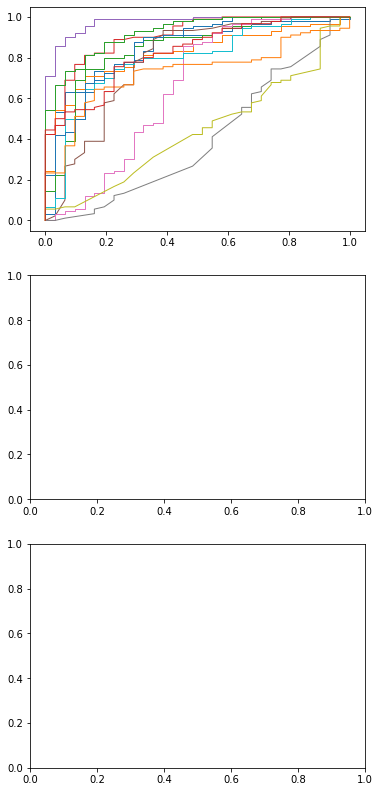

In [12]:
plt.rcParams['figure.figsize'] = [6,14]
fig, ax = plt.subplots(3, 1)

compare(ax[0],dominant, savesemicol(balanced_model_all,'MPC'), 'dominant_trained')
ax[0].legend(loc='center', bbox_to_anchor= (1.45,0.5), ncol=1,fancybox=True, shadow=True)
ax[0].set_xlabel('')
ax[0].set_ylabel('True Positive Rate')
compare(ax[1],recessive, savesemicol(balanced_model_all,'MPC'), 'recessive_trained')
ax[1].legend(loc='center', bbox_to_anchor= (1.45,0.47), ncol=1,fancybox=True, shadow=True)
ax[1].set_xlabel('')
ax[1].set_ylabel('True Positive Rate')
compare(ax[2], omit, omit_model_all, "model trained by variants with unknown mode of inheritance")
ax[2].legend(loc='center', bbox_to_anchor= (1.45,0.44), ncol=1,fancybox=True, shadow=True)
ax[0].text(-0.2, 1, 'A', size = 18)
ax[1].text(-0.2, 1, 'B', size = 18)
ax[2].text(-0.2, 1, 'C', size = 18)
ax[2].set_xlabel('False Positive Rate')
ax[2].set_ylabel('True Positive Rate')


In [15]:
fig.savefig('figure/5_model_comparison_all.pdf',bbox_inches = "tight")

/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


training set = 965,
testing set = 121,
validation set = 120


/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
With score : 0.757

Grid scores on development set:



/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


training set = 977,
testing set = 123,
validation set = 121


/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
With score : 0.798

Grid scores on development set:



/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


training set = 32076,
testing set = 4005,
validation set = 3965


/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
With score : 0.843

Grid scores on development set:



Text(0, 0.5, 'True Positive Rate')

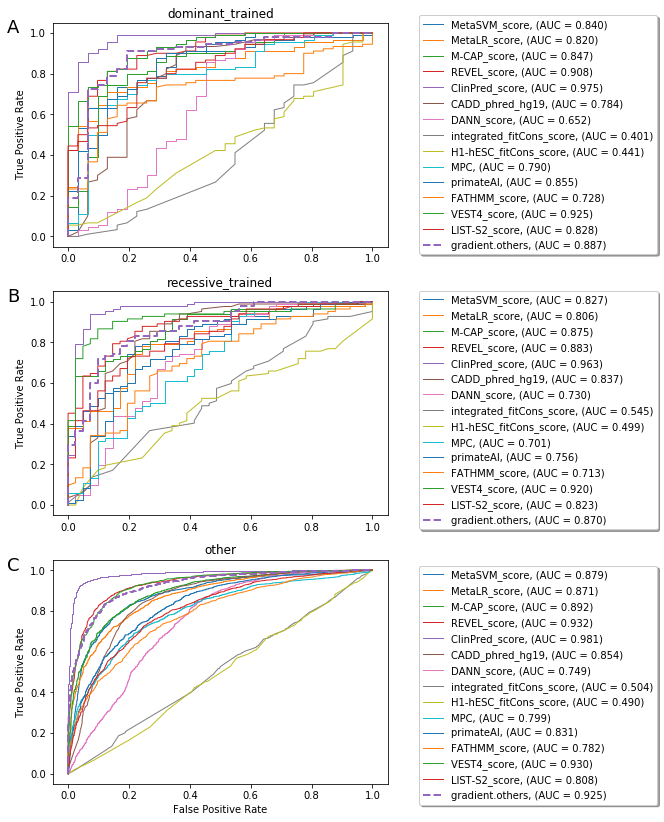

In [182]:
plt.rcParams['figure.figsize'] = [6,14]
fig, ax = plt.subplots(3, 1)

compare(ax[0],dominant, savesemicol(balanced_model_all,'MPC'), 'dominant_trained')
ax[0].legend(loc='center', bbox_to_anchor= (1.45,0.5), ncol=1,fancybox=True, shadow=True)
ax[0].set_xlabel('')
ax[0].set_ylabel('True Positive Rate')
compare(ax[1],recessive, savesemicol(balanced_model_all,'MPC'), 'recessive_trained')
ax[1].legend(loc='center', bbox_to_anchor= (1.45,0.47), ncol=1,fancybox=True, shadow=True)
ax[1].set_xlabel('')
ax[1].set_ylabel('True Positive Rate')
compare(ax[2], omit, omit_model_all, "other")
ax[2].legend(loc='center', bbox_to_anchor= (1.45,0.44), ncol=1,fancybox=True, shadow=True)
ax[0].text(-0.2, 1, 'A', size = 18)
ax[1].text(-0.2, 1, 'B', size = 18)
ax[2].text(-0.2, 1, 'C', size = 18)
ax[2].set_xlabel('False Positive Rate')
ax[2].set_ylabel('True Positive Rate')



In [13]:
fig.savefig('figure/5_model_comparison_all.pdf',bbox_inches = "tight")

/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


training set = 32076,
testing set = 4005,
validation set = 3965


/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
With score : 0.843

Grid scores on development set:



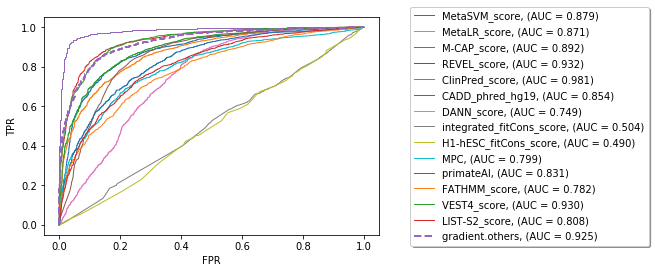

In [149]:
plt.rcParams['figure.figsize'] = [6,4]
fig, ax = plt.subplots(1, 1)
compare(ax, omit, omit_model_all, "")
ax.legend(loc='center', bbox_to_anchor= (1.45,0.5), ncol=1,fancybox=True, shadow=True)


In [98]:
fig.savefig('figure/5_model_comparison_all.pdf',bbox_inches = "tight")

training set = 14422,
testing set = 1801,
validation set = 1783


/storage/home/jkl5991/.conda/envs/sanEnv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Best parameters set found on development set:
{'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 200}
With score : 0.860

Grid scores on development set:



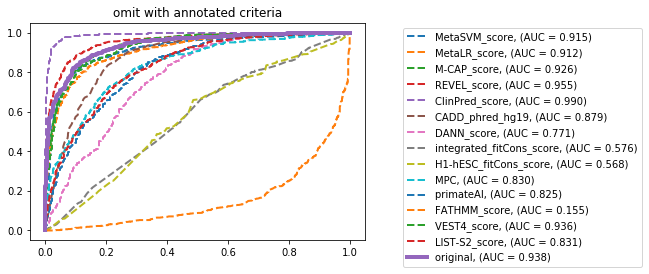

In [138]:
test_with_critera = compare(omit_with_criteria, omit_model_all, "omit with annotated criteria",newfeatures = features_all, allcolumnname = original_column + features_all)

In [178]:
new = merge_with_original_df(omit, omit_model_all)

In [179]:
new

,location,accession_num,clinvar_result,SIFT_pred,LRT_pred,MA_pred,PROVEN_pred,SLR_score,SIFT_score,LRT_omega,...,M-CAP_score,REVEL_score,ClinPred_score,LIST-S2_score,CADD_phred_hg19,DANN_score,integrated_fitCons_score,H1-hESC_fitCons_score,MPC,primateAI
0,chr1-865627-865628-G-A,ENSG00000187634.6|SAMD11,0,1,0,1,1,0.567591,-0.560382,-0.028677,...,.,0.086,0.034906782148642,0.907609,20.600,0.985760,0.59774,0.596491,0.00828984788232,0.54737830162
1,chr1-879480-879481-G-C,ENSG00000187634.6|SAMD11,0,1,1,1,1,0.139500,-0.611212,-0.028677,...,.,0.102,0.034695620173236,0.925307,17.160,0.991843,0.498214,0.578056,0.039677896012,0.560074031353
2,chr1-891392-891393-G-A,ENSG00000188976.6|NOC2L,0,0,0,0,0,0.017887,3.501810,-0.028677,...,0.117497,0.168,0.011943571039473,0.591441,18.710,0.609726,0.706548,0.724815,.,0.536460161209
3,chr1-897008-897009-A-G,ENSG00000187961.9|KLHL17,0,0,0,0,0,0.017887,1.453542,-0.028267,...,0.025404,0.199,0.0632387617366854,0.910909,17.800,0.757441,0.740716,0,.,0.70530462265
4,chr1-901921-901922-G-A,ENSG00000187583.6|PLEKHN1,0,1,0,0,0,0.017887,-0.288379,-0.026846,...,.,0.053,0.0134808743801778,0.693531,22.600,0.993577,0.56387,0.503968,0.0119885482338,0.646891474724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71009,chrY-2655441-2655442-A-G,ENSG00000184895.6|SRY,1,1,0,1,1,0.017887,-0.615334,0.000248,...,0.996812,0.686,0.969242990016937,0.949105,21.200,0.974449,.,.,1.09219383268,.
71010,chrY-2655452-2655453-C-T,ENSG00000184895.6|SRY,1,1,0,1,1,0.017887,-0.605029,0.000248,...,0.996204,0.750,0.971387386322021,0.889911,22.300,0.983292,.,.,1.14559421498,.
71011,chrY-2655466-2655467-C-G,ENSG00000184895.6|SRY,1,1,0,1,1,0.017887,-0.615334,0.000248,...,0.997799,0.690,0.989319801330566,0.974702,17.740,0.952624,.,.,1.09064254846,.
71012,chrY-2655555-2655556-C-A,ENSG00000184895.6|SRY,1,1,0,0,1,0.017887,-0.602968,0.000248,...,0.997982,0.608,0.840452134609222,0.915508,15.650,0.958270,.,.,1.04302437704,.


In [180]:
new.to_csv('/storage/home/jkl5991/work/project/not_conflict/all_model_new.tsv', sep = '\t',index = False)

In [ ]:
# output2 (not included MPC and primateAI)
#tabix output2.bed.bgz -R non_ssc_sortedloc.bed > tabix_non_ssc_othermodel.tsv